# Weekly vs biweeky investment strategies comparison

In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from typing import List
%matplotlib inline

VTSAX prices data from https://finance.yahoo.com/quote/VTSAX/history

In [2]:
df_vtsax = pd.read_csv('Data/VTSAX.csv').sort_values('Date')
df_vtsax.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2016-09-06,54.810001,54.810001,54.810001,54.810001,50.053112,0
1,2016-09-07,54.869999,54.869999,54.869999,54.869999,50.107899,0
2,2016-09-08,54.740002,54.740002,54.740002,54.740002,49.989178,0
3,2016-09-09,53.360001,53.360001,53.360001,53.360001,48.728954,0
4,2016-09-12,53.860001,53.860001,53.860001,53.860001,49.428246,0


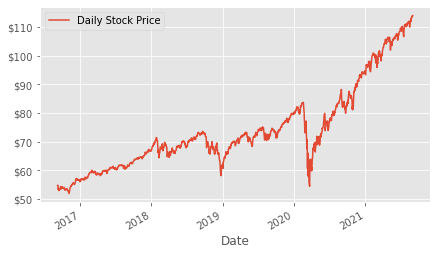

In [3]:
df_vtsax['Date'] = pd.to_datetime(df_vtsax['Date'])
with plt.style.context('ggplot'):
    fig, ax = plt.subplots(figsize=(7,4))
    df_vtsax.plot(x='Date', y='Open', ax=ax, label='Daily Stock Price')
    ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('${x:,.0f}'))

In [4]:
# additional parameters for each date
df_vtsax['DayOfWeek'] = df_vtsax['Date'].dt.dayofweek
df_vtsax['Year'] = df_vtsax['Date'].dt.year
df_vtsax['WeekOfYear'] = df_vtsax['Date'].dt.isocalendar().week

In [5]:
# biweekly investment either fully invested or distributed in weekly payments
bw_investment = 1000.0

def buy_shares(df: pd.DataFrame, col_in: str, col_sh: str) -> pd.DataFrame:
    """
    Imitate stock buying
    col_in: Incestment column name
    col_sh: Number of shares column name
    """
    # the purchased number of shares
    df[col_sh] = df[col_in]/df['Price']
    # the cumulative number of shares to each date
    df['Cum' + col_sh] = df[col_sh].cumsum()
    # how much do all the purchased shares cost on each date
    df['Worth' + col_sh] = df['Cum' + col_sh]*df['Price']
    return df

df_vtsax_weekly = (
    df_vtsax
    # take the first day price from each week
    .groupby(['Year', 'WeekOfYear'], group_keys=False)
    .apply(lambda df: df.nsmallest(1, 'DayOfWeek'))
    # renumber all the rows from 0
    .reset_index(drop=True)
    .reset_index()
    .rename(columns={'index':'WeekNumber', 'Open':'Price'})
    # create the column for weekly investments
    .assign(WeeklyInvestment = bw_investment/2)
    # buy shares weekly
    .pipe(buy_shares, 'WeeklyInvestment', 'WeeklyShares')
    # create the column for bi-weekly investments
    .assign(BiweeklyInvestment = lambda df_:np.where(df_['WeekNumber'] % 2 == 0, bw_investment, 0))
    # buy shares bi-weekly
    .pipe(buy_shares, 'BiweeklyInvestment', 'BiweeklyShares')
    # generate overall investments
    .assign(Investment = lambda df:df['WeeklyInvestment'].cumsum())
    # generate the difference in the number of accumulated shares
    .assign(SharesDiff = lambda df:df['CumBiweeklyShares'] - df['CumWeeklyShares'])
    # generate the difference in the dollar amount difference
    .assign(WorthDiff = lambda df:df['WorthBiweeklyShares'] - df['WorthWeeklyShares'])
)

# guarding from investing extra week if the number of weeks is odd
if df_vtsax_weekly['WeeklyInvestment'].sum() != df_vtsax_weekly['BiweeklyInvestment'].sum():
    df_vtsax_weekly = df_vtsax_weekly[:-1]

# drop the weekly results for the fair comparison
df_cmp = df_vtsax_weekly[lambda df:df['WeekNumber'] % 2 == 1]

df_cmp.head()

,WeekNumber,Date,Price,High,Low,Close,Adj Close,Volume,DayOfWeek,Year,...,WeeklyShares,CumWeeklyShares,WorthWeeklyShares,BiweeklyInvestment,BiweeklyShares,CumBiweeklyShares,WorthBiweeklyShares,Investment,SharesDiff,WorthDiff
1,1,2016-09-12,53.860001,53.860001,53.860001,53.860001,49.428246,0,0,2016,...,9.283327,18.405750,991.333698,0.0,0.0,18.244845,982.667397,1000.0,-0.160904,-8.666302
3,3,2016-09-26,53.660000,53.660000,53.660000,53.660000,49.244709,0,0,2016,...,9.317928,37.081716,1989.804879,0.0,0.0,36.960923,1983.323107,2000.0,-0.120793,-6.481772
5,5,2016-10-10,54.090000,54.090000,54.090000,54.090000,49.639332,0,0,2016,...,9.243853,55.581400,3006.397925,0.0,0.0,55.472585,3000.512120,3000.0,-0.108815,-5.885805
7,7,2016-10-24,53.720001,53.720001,53.720001,53.720001,49.299778,0,0,2016,...,9.307520,74.306890,3991.766193,0.0,0.0,74.308524,3991.853980,4000.0,0.001634,0.087787
9,9,2016-11-07,53.130001,53.130001,53.130001,53.130001,48.758320,0,0,2016,...,9.410879,93.151731,4949.151552,0.0,0.0,93.176448,4950.464800,5000.0,0.024718,1.313247


In [6]:
def plot_prices(df: pd.DataFrame, y_cols: List[str], title: str):
    with plt.style.context('ggplot'):
        fig, ax = plt.subplots(figsize=(7,5))
        df.plot(x='Date', y=y_cols, style=['-', '--', '-.'], ax=ax)
        ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('${x:,.0f}'))
        ax.set_title(title)

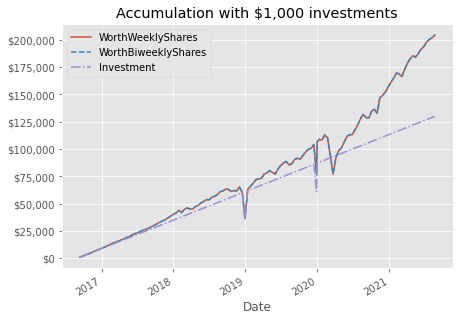

In [7]:
plot_prices(
    df_cmp,
    ['WorthWeeklyShares', 'WorthBiweeklyShares', 'Investment'],
    f'Accumulation with ${bw_investment:,.0f} investments'
)

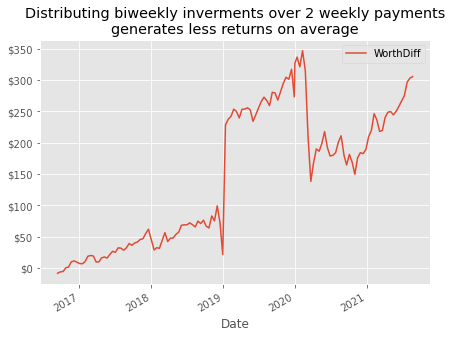

In [8]:
plot_prices(
    df_cmp,
    ['WorthDiff'],
    f'Distributing biweekly inverments over 2 weekly payments\ngenerates less returns on average'
)